In [4]:
import sys
!$sys.executable -m pip install tensorflow ##Installing tensorflow

     |████████████████████████████████| 241.2 MB 91 kB/s s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 438 kB 36.7 MB/s eta 0:00:01
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached grpcio-1.50.0-cp38-cp38-macosx_10_10_x86_64.whl (4.5 MB)
     |████████████████████████████████| 5.9 MB 15.8 MB/s eta 0:00:01
  Using cached protobuf-3.19.6-cp38-cp38-macosx_10_9_x86_64.whl (980 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp38-cp38-macosx_10_14_x86_64.whl (1.6 MB)

In [2]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

In [6]:
tf.random.set_seed(6)

In [4]:
file = 'Dowpredictive.csv'
raw_data = pd.read_csv(file, parse_dates = ['Date'], index_col = "Date")

df = raw_data.copy()
df = df.iloc[::-1]
df.head()

,ChangeDow,save.Value,CPI,EquityMktUncertainty,CrudeOilPrice,FederalReserveLoans,FedReservesOnHand,EconomicPolicy,Index,ExpectedStockIncrease,ConsumerUnemployment
Date,,,,,,,,,,,
2010-07-31,0.070792,6.4,217.923,50.61,20.74,49773,995.183,1.727273,67.8,44.7,2.111111
2010-08-31,-0.043113,6.5,218.275,125.02,24.42,47564,1003.206,1.808081,68.9,45.4,2.120000
2010-09-30,0.077219,6.5,219.035,104.46,26.27,46685,1011.124,1.757576,68.2,45.2,2.141414
2010-10-31,0.030630,6.3,219.590,18.75,27.02,45084,1027.089,1.656566,67.7,46.4,2.132653
2010-11-30,-0.010116,6.1,220.472,5.63,25.52,23259,1078.051,1.690000,71.6,50.5,2.080808


<AxesSubplot:xlabel='Date'>

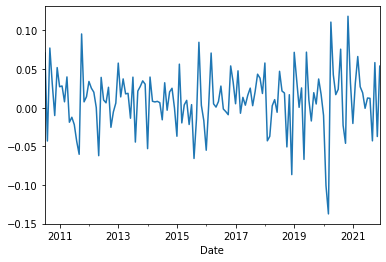

In [6]:
Dow = df['ChangeDow']
Dow.plot()

In [7]:
def dfToXY(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

In [8]:
x,y = dfToXY(df, 4)
x.shape, y.shape

((134, 4, 11), (134,))

In [9]:
x = np.squeeze(x) #getting rid of the third dimension (=value 1) from x array
x.shape

(134, 4, 11)

In [10]:
trainSize = int(len(df)*0.80)
valSize = int(len(df)*.05)
xTrain, yTrain = x[:trainSize], y[:trainSize]
xVal, yVal = x[trainSize:trainSize+valSize], y[trainSize:trainSize+valSize]
xTest, yTest = x[trainSize+valSize:], y[trainSize+valSize:]
xTrain.shape, yTrain.shape, xVal.shape,yVal.shape,xTest.shape, yTest.shape

((110, 4, 11), (110,), (6, 4, 11), (6,), (18, 4, 11), (18,))

In [11]:
DowTrainMean = np.mean(xTrain[:, :, 0])
DowTrainStd = np.std(xTrain[:, :, 0])

#print(BitTrainMean)
#print(BitTrainStd)                   

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - DowTrainMean) / DowTrainStd
    return x

In [12]:
preprocess(xTrain)
preprocess(xVal)
preprocess(xTest)

array([[[-4.36565853e+00,  1.31000000e+01,  2.56094000e+02,
          3.40990000e+02,  8.64100000e+01,  1.06896000e+05,
          3.26814400e+03,  2.15151515e+00,  8.91000000e+01,
          5.76000000e+01,  2.18181818e+00],
        [ 3.01295669e+00,  3.38000000e+01,  2.55944000e+02,
          1.61980000e+02,  9.72100000e+01,  9.53600000e+04,
          2.91875600e+03,  2.00000000e+00,  7.18000000e+01,
          5.62000000e+01,  2.18181818e+00],
        [ 9.85963081e-01,  2.48000000e+01,  2.57217000e+02,
          4.20900000e+01,  9.85700000e+01,  9.05230000e+04,
          2.61527200e+03,  1.90625000e+00,  7.23000000e+01,
          5.39000000e+01,  1.93939394e+00],
        [ 2.22686663e-01,  1.93000000e+01,  2.58543000e+02,
          1.08710000e+02,  1.00240000e+02,  8.11050000e+04,
          2.81579400e+03,  1.86597938e+00,  7.81000000e+01,
          5.50000000e+01,  1.75510204e+00]],

       [[ 3.01295669e+00,  3.38000000e+01,  2.55944000e+02,
          1.61980000e+02,  9.72100000e+01,

In [13]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [17]:
model1 = Sequential()
model1.add(InputLayer((4, 10)))
model1.add(LSTM(100))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               44800     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 45,617
Trainable params: 45,617
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp = ModelCheckpoint("model1/", save_best_only = True, monitor = "loss")
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model1.fit(xTrain,yTrain,validation_data = (xVal, yVal),epochs = 10, callbacks =[cp])

Epoch 1/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.2271

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0541 - root_mean_squared_error: 0.2326 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2418
Epoch 2/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.2222

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2355
Epoch 3/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2120

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0432 - root_mean_squared_error: 0.2078 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2654
Epoch 4/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.2085

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0403 - root_mean_squared_error: 0.2006 - val_loss: 0.0726 - val_root_mean_squared_error: 0.2695
Epoch 5/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.2077

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2632
Epoch 6/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - root_mean_squared_error: 0.1911

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2569
Epoch 7/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1822

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0330 - root_mean_squared_error: 0.1818 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2508
Epoch 8/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - root_mean_squared_error: 0.1840

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2450
Epoch 9/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1702

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2402
Epoch 10/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0304 - root_mean_squared_error: 0.1744

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0277 - root_mean_squared_error: 0.1665 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2356


In [34]:
trainPredictions = model1.predict(xTrain).flatten()
trainResults = pd.DataFrame(
    data = {'Train Predictions':trainPredictions,
    "Actuals":yTrain})
trainResults

4/4 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,0.153059,-0.010116
1,0.149728,0.051925
2,0.120902,0.027158
3,0.112753,0.028121
4,0.123429,0.007638
...,...,...
105,0.154103,-0.017160
106,0.273740,0.019450
107,0.282316,0.004807
108,0.194412,0.037165


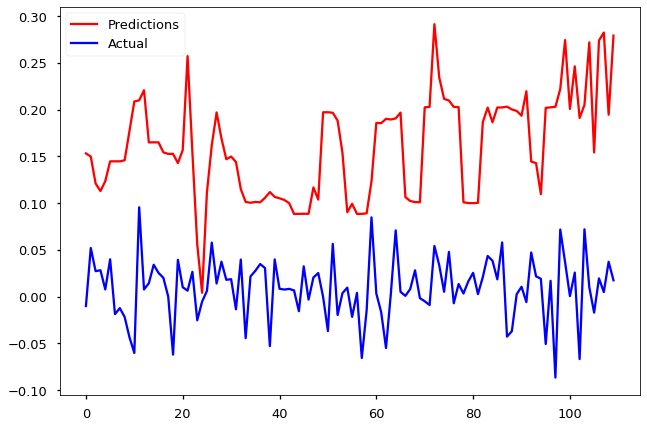

In [60]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.plot(trainResults['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [36]:
testPredictions = model1.predict(xTest).flatten()
testResults = pd.DataFrame(
    data = {'Test Predictions':testPredictions,
    "Actuals":yTest})
testResults

1/1 [==============================] - 0s 38ms/step


,Test Predictions,Actuals
0,0.153059,0.023842
1,0.153059,0.075742
2,0.153059,-0.022805
3,0.149728,-0.046077
4,0.120896,0.118372
5,0.112740,0.032655
6,0.113433,-0.020383
7,0.113433,0.031677
8,0.113433,0.066247
9,0.113433,0.027085


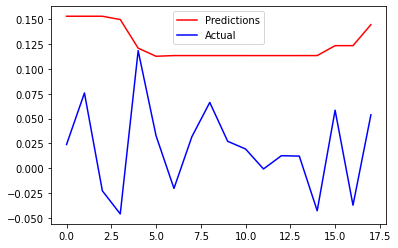

In [37]:
plt.plot(testResults['Test Predictions'], "-r")
plt.plot(testResults['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [38]:
rmse = np.sqrt(np.mean(testPredictions - yTest)**2)
rmse

0.10518269157417488

In [39]:
mae = np.mean(abs(testPredictions - yTest))
mae

0.10518269157417488

In [58]:
trainrmse = np.sqrt(np.mean(trainPredictions - yTrain)**2)
trainrmse

0.15077707268807428

In [59]:
trainmae = np.mean(abs(trainPredictions - yTrain))
trainmae

0.15077707268807428

In [40]:
model2 = Sequential()
model2.add(InputLayer((4, 10)))
model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(LSTM(100, activation = 'relu', return_sequences = True))
model2.add(LSTM(100))
model2.add(Dropout(0.1))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4, 100)            44800     
                                                                 
 lstm_6 (LSTM)               (None, 4, 100)            80400     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 205,701
Trainable params: 205,701
Non-trainable params: 0
_________________________________________________________________


In [41]:
cp2 = ModelCheckpoint("model2/", save_best_only = True, monitor = "loss")
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [42]:
model2.fit(xTrain,yTrain,validation_data = (xVal,yVal),epochs = 25, callbacks =[cp2])

Epoch 1/25
1/4 [======>.......................] - ETA: 13s - loss: 0.2835 - root_mean_squared_error: 0.5324

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 12s 2s/step - loss: 0.2645 - root_mean_squared_error: 0.5143 - val_loss: 0.4087 - val_root_mean_squared_error: 0.6393
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.2268 - root_mean_squared_error: 0.4762

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.2268 - root_mean_squared_error: 0.4762 - val_loss: 0.4015 - val_root_mean_squared_error: 0.6336
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.1964 - root_mean_squared_error: 0.4432

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1964 - root_mean_squared_error: 0.4432 - val_loss: 0.3521 - val_root_mean_squared_error: 0.5934
Epoch 4/25
1/4 [======>.......................] - ETA: 0s - loss: 0.2238 - root_mean_squared_error: 0.4730

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1924 - root_mean_squared_error: 0.4386 - val_loss: 0.3583 - val_root_mean_squared_error: 0.5986
Epoch 5/25
4/4 [==============================] - ETA: 0s - loss: 0.1451 - root_mean_squared_error: 0.3809

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1451 - root_mean_squared_error: 0.3809 - val_loss: 0.3415 - val_root_mean_squared_error: 0.5843
Epoch 6/25
4/4 [==============================] - ETA: 0s - loss: 0.1451 - root_mean_squared_error: 0.3809

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.1451 - root_mean_squared_error: 0.3809 - val_loss: 0.3458 - val_root_mean_squared_error: 0.5880
Epoch 7/25
4/4 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3529

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1245 - root_mean_squared_error: 0.3529 - val_loss: 0.3509 - val_root_mean_squared_error: 0.5924
Epoch 8/25
1/4 [======>.......................] - ETA: 0s - loss: 0.1031 - root_mean_squared_error: 0.3210

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1213 - root_mean_squared_error: 0.3484 - val_loss: 0.3022 - val_root_mean_squared_error: 0.5497
Epoch 9/25
4/4 [==============================] - 0s 26ms/step - loss: 0.1426 - root_mean_squared_error: 0.3777 - val_loss: 0.2951 - val_root_mean_squared_error: 0.5433
Epoch 10/25
4/4 [==============================] - 0s 23ms/step - loss: 0.1510 - root_mean_squared_error: 0.3886 - val_loss: 0.3344 - val_root_mean_squared_error: 0.5783
Epoch 11/25
4/4 [==============================] - 0s 34ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.3297 - val_root_mean_squared_error: 0.5742
Epoch 12/25
4/4 [==============================] - 0s 27ms/step - loss: 0.1303 - root_mean_squared_error: 0.3610 - val_loss: 0.4594 - val_root_mean_squared_error: 0.6778
Epoch 13/25
4/4 [==============================] - 0s 20ms/step - loss: 0.1742 - root_mean_squared_error: 0.4174 - val_loss: 0.5799 - val_root_mean_squared_error: 0.

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1166 - root_mean_squared_error: 0.3414 - val_loss: 0.4633 - val_root_mean_squared_error: 0.6807
Epoch 18/25
4/4 [==============================] - 0s 23ms/step - loss: 0.1305 - root_mean_squared_error: 0.3612 - val_loss: 0.4798 - val_root_mean_squared_error: 0.6927
Epoch 19/25
1/4 [======>.......................] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3413

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1050 - root_mean_squared_error: 0.3241 - val_loss: 0.4932 - val_root_mean_squared_error: 0.7023
Epoch 20/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0869 - root_mean_squared_error: 0.2948

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.0802 - root_mean_squared_error: 0.2831 - val_loss: 0.4939 - val_root_mean_squared_error: 0.7028
Epoch 21/25
4/4 [==============================] - 0s 26ms/step - loss: 0.1045 - root_mean_squared_error: 0.3232 - val_loss: 0.4481 - val_root_mean_squared_error: 0.6694
Epoch 22/25
4/4 [==============================] - 0s 22ms/step - loss: 0.1085 - root_mean_squared_error: 0.3293 - val_loss: 0.4127 - val_root_mean_squared_error: 0.6424
Epoch 23/25
4/4 [==============================] - 0s 35ms/step - loss: 0.0814 - root_mean_squared_error: 0.2853 - val_loss: 0.4180 - val_root_mean_squared_error: 0.6466
Epoch 24/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0872 - root_mean_squared_error: 0.2953

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0799 - root_mean_squared_error: 0.2826 - val_loss: 0.3205 - val_root_mean_squared_error: 0.5661
Epoch 25/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0790 - root_mean_squared_error: 0.2811

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0780 - root_mean_squared_error: 0.2794 - val_loss: 0.4295 - val_root_mean_squared_error: 0.6554


In [43]:
trainPredictions2 = model2.predict(xTrain).flatten()
trainResults2 = pd.DataFrame(
    data = {'Train Predictions':trainPredictions2,
    "Actuals":yTrain})
trainResults2

4/4 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,-0.105679,-0.010116
1,0.217284,0.051925
2,0.046999,0.027158
3,0.279401,0.028121
4,0.350463,0.007638
...,...,...
105,-0.005241,-0.017160
106,-0.156556,0.019450
107,-0.240375,0.004807
108,0.073232,0.037165


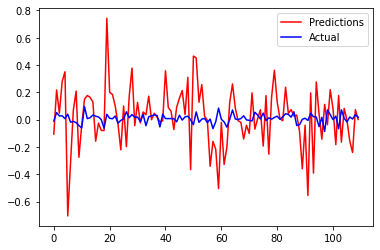

In [44]:
plt.plot(trainResults2['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults2['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [45]:
testPredictions2 = model2.predict(xTest).flatten()
testResults2 = pd.DataFrame(
    data = {'Test Predictions':testPredictions2,
    "Actuals":yTest})
testResults2

1/1 [==============================] - 0s 30ms/step


,Test Predictions,Actuals
0,0.780356,0.023842
1,0.480277,0.075742
2,0.783755,-0.022805
3,1.023612,-0.046077
4,0.603445,0.118372
5,0.657665,0.032655
6,-0.336026,-0.020383
7,0.154171,0.031677
8,0.378117,0.066247
9,0.558708,0.027085


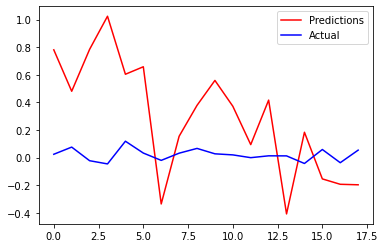

In [46]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [48]:
rmse = np.sqrt(np.mean(testPredictions2 - yTest)**2)
rmse

0.2685254356861897

In [49]:
mae = np.mean(abs(testPredictions2 - yTest))
mae

0.41923511182999273

In [56]:
trainrmse = np.sqrt(np.mean(trainPredictions2 - yTrain)**2)
trainrmse

0.01172653393059698

In [57]:
trainmae = np.mean(abs(trainPredictions2 - yTrain))
trainmae

0.15934054441004858

In [55]:
from keras.models import load_model
    
model2.save('DowModel2.h5')  # creates a HDF5 file 'my_model.h5'
model2 = load_model('DowModel2.h5')# returns a compiled model identical to the previous one

In [47]:
raw_data = pd.read_csv(file,parse_dates = ["Date"], index_col = False)
df1 = raw_data.copy()

Dates = df1.iloc[::-1]
Dates = Dates["Date"]
Dates.head()

137   2010-07-31
136   2010-08-31
135   2010-09-30
134   2010-10-31
133   2010-11-30
Name: Date, dtype: datetime64[ns]

In [50]:
trainSize = int(len(Dates)*0.80)
valSize = int(len(Dates)*.05)

trainDates = Dates[:trainSize]
testDates = Dates[trainSize+valSize:]

In [51]:
trainDates = Dates[0:109]
testDates = Dates[120:138]

trainDates = trainDates.reset_index()
testDates = testDates.reset_index()

trainDates = trainDates.pop('Date')
testDates = testDates.pop('Date')

#trainDates
#testDates

In [52]:
trainResults2 = pd.concat([trainResults2,trainDates],axis=1)
testResults2 = pd.concat([testResults2,testDates],axis=1)

trainResults2 = trainResults2.set_index("Date")
testResults2 = testResults2.set_index("Date")


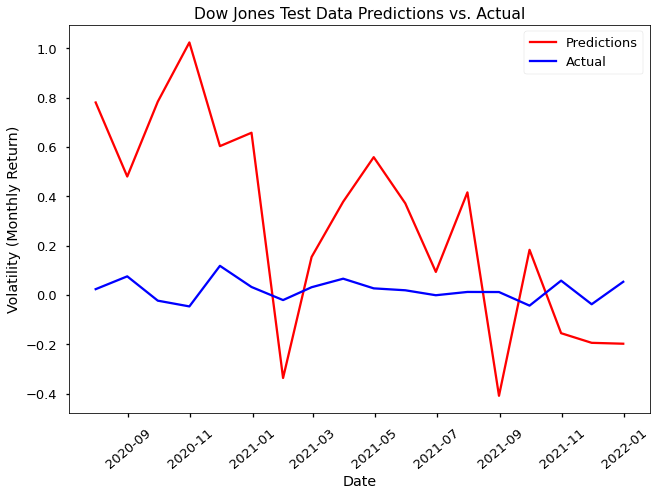

In [62]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Dow Jones Test Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

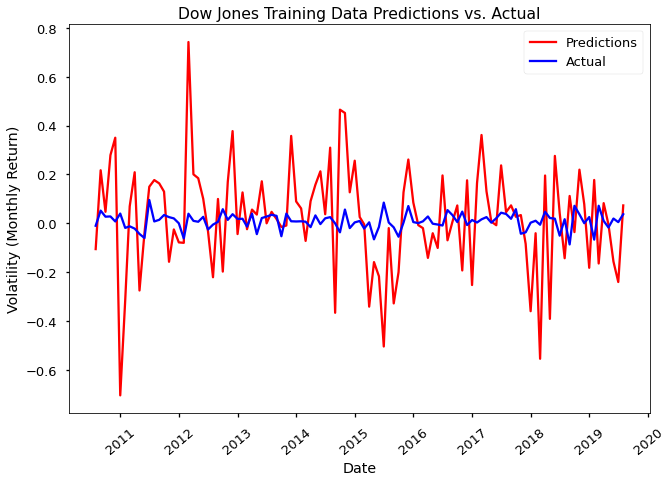

In [61]:
plt.plot(trainResults2['Train Predictions'], "-r")
plt.plot(trainResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Dow Jones Training Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [63]:
trainResults2.to_csv('DowTrainResults.csv')
testResults2.to_csv('DowTestResults.csv')